In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import pickle as pkl
import os
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [2]:
def drops(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last:
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [3]:
def stability_window(y, mw_size):
    mw = deque()
    mw_average = []
    mw_std = []
    for i in y:
        mw.append(i)
        if len(mw) > mw_size:
            mw.popleft()
        mw_average.append(np.mean(mw))
        mw_std.append(np.std(mw))
    mw_average = np.array(mw_average)
    mw_std = np.array(mw_std)

    outliers_pos = []
    for pos, i in enumerate(y):
        if i < (mw_average - mw_std)[pos]:
            outliers_pos.append(pos)
            
    return mw_average, mw_std, outliers_pos

In [9]:
dataset_label = 'bpic17'
classifier = 'lstm'
evaluation_method ='F1'
with open('../result/%s/%s/Finished cases/prefix_1_%s update.pkl'%(dataset_label, classifier, evaluation_method), 'rb') as data:
    result = pkl.load(data)

In [167]:
dataset_label = 'bpic17'
classifier = 'hatc'
evaluation_method ='Accuracy'
result = {}
for i in range(1, 16):
    with open('../result/%s/%s/Finished cases/prefix_%s_%s update.pkl'%(dataset_label, classifier, i, evaluation_method), 'rb') as data:
        result[i] = pkl.load(data)[i]

print(len(result[1].keys()))
if classifier =='xgb':
    for prefix in result.keys():
        for update in result[prefix]:
            y_pred_label = []
            for i in result[prefix][update]['y_pred']:
            #     print(i)
                if np.argmax(i) == 0:
                    label = 'False'
                else:
                    label = 'True'
                y_pred_label.append(label)
            result[prefix][update]['y_pred'] = y_pred_label

1335


In [8]:
result.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [7]:
result = {i:result[i] for i in range(1,len(result[1].keys()))}
# for i in result.keys():
#     print(i, len(result[i]))

KeyError: 16

In [10]:
for t in list(result.keys()):
    ndict = dict()
    
    for i in range(30,len(result[1].keys())):
        if i not in list(result[t].keys()):
            if i-1 not in list(result[t].keys()):
                value = result[t][min(list(result[t].keys()))]
            else:
                value = result[t][i-1]
            result[t][i] = value
        else:
            value = result[t][i]
        ndict[i] = value
    result[t] = ndict

In [11]:
evaluation_method = 'F1'
score_dict = {}
for prefix in result:
    score_dict[prefix] = []
    for i in result[prefix]:
        y_true = result[prefix][i]['y_true']
        y_pred = result[prefix][i]['y_pred']
        if classifier =='hatc':
            y_pred_n = []
            for t in y_pred:
                s = sorted(t.items(), key=lambda x: x[1], reverse=True)[0][0]
                y_pred_n.append(s)
            y_pred = y_pred_n
        if evaluation_method == 'Accuracy':
            score_dict[prefix].append(accuracy_score(y_true, y_pred))
        elif evaluation_method == 'F1':
            score_dict[prefix].append(f1_score(y_true, y_pred, average='weighted'))


1


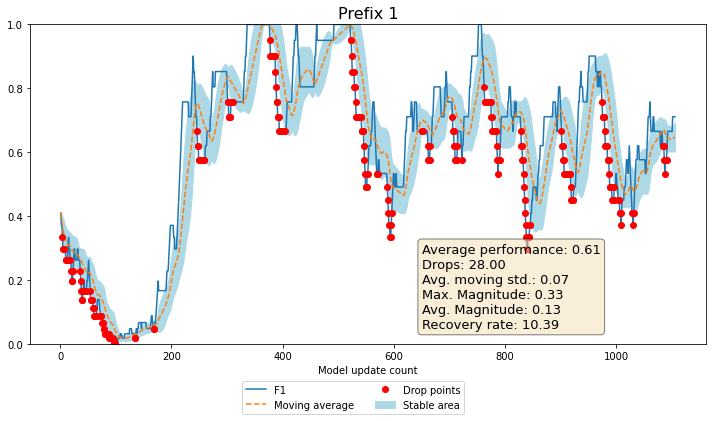

../img/bpic17/lstm/Finished cases/prefix_1_F1 update.png
2


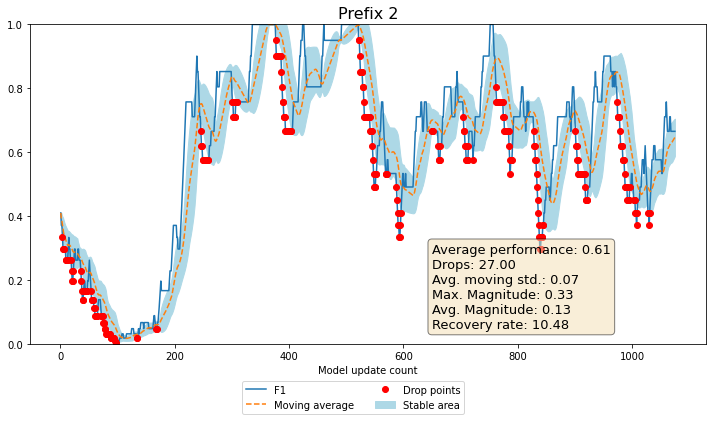

../img/bpic17/lstm/Finished cases/prefix_2_F1 update.png
3


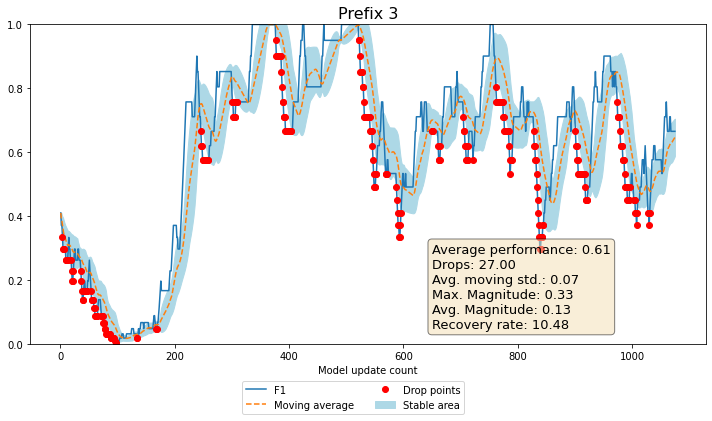

../img/bpic17/lstm/Finished cases/prefix_3_F1 update.png
4


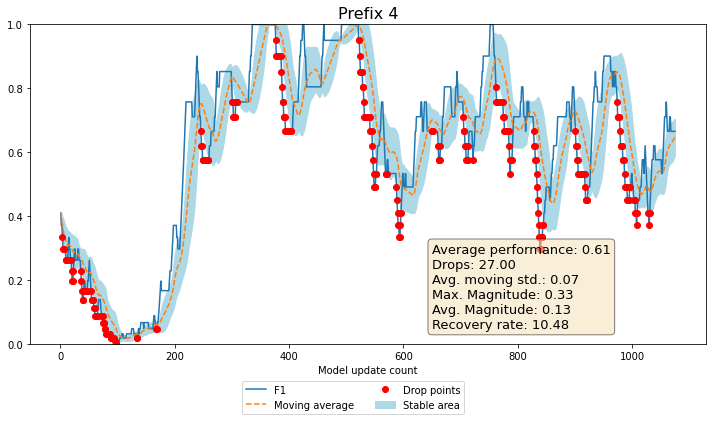

../img/bpic17/lstm/Finished cases/prefix_4_F1 update.png
5


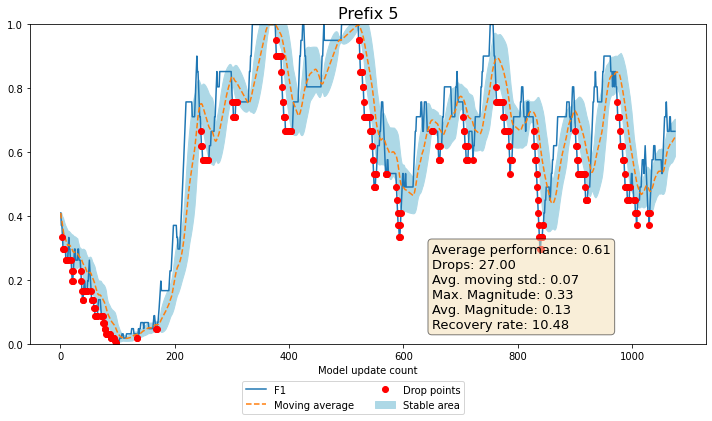

../img/bpic17/lstm/Finished cases/prefix_5_F1 update.png
6


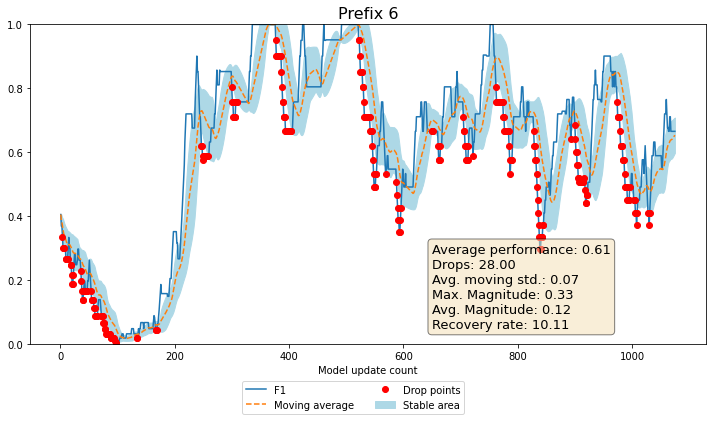

../img/bpic17/lstm/Finished cases/prefix_6_F1 update.png
7


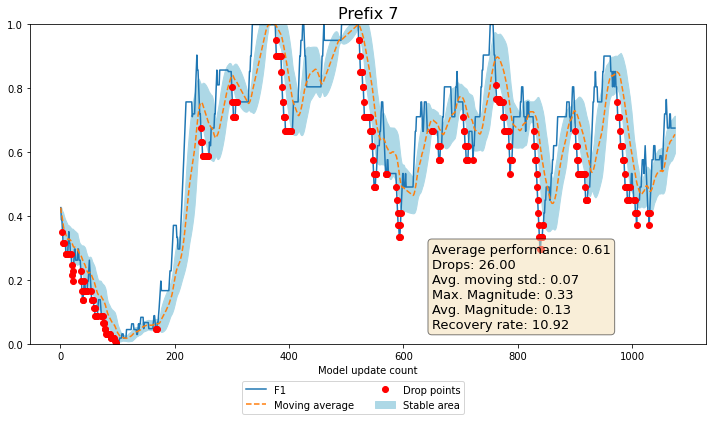

../img/bpic17/lstm/Finished cases/prefix_7_F1 update.png
8


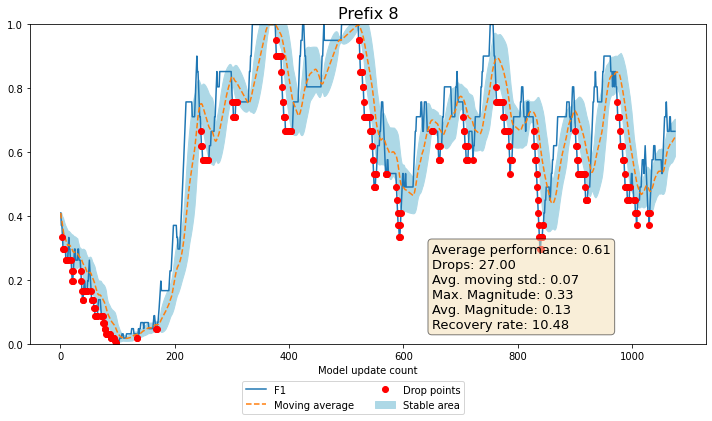

../img/bpic17/lstm/Finished cases/prefix_8_F1 update.png
9


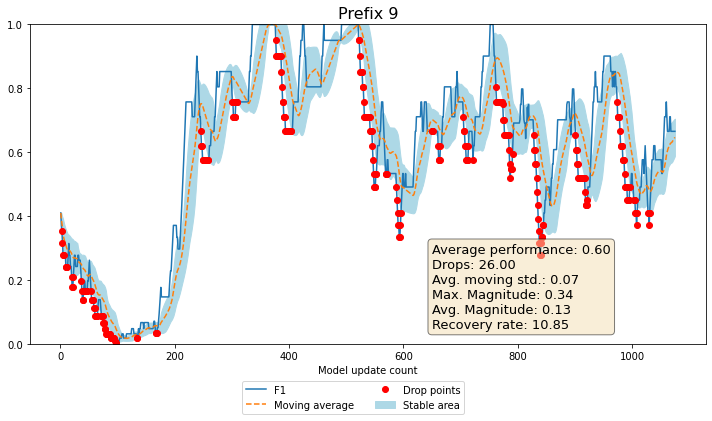

../img/bpic17/lstm/Finished cases/prefix_9_F1 update.png
10


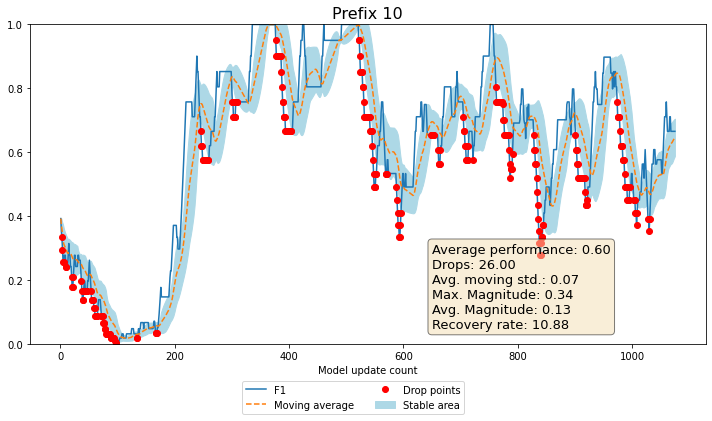

../img/bpic17/lstm/Finished cases/prefix_10_F1 update.png
11


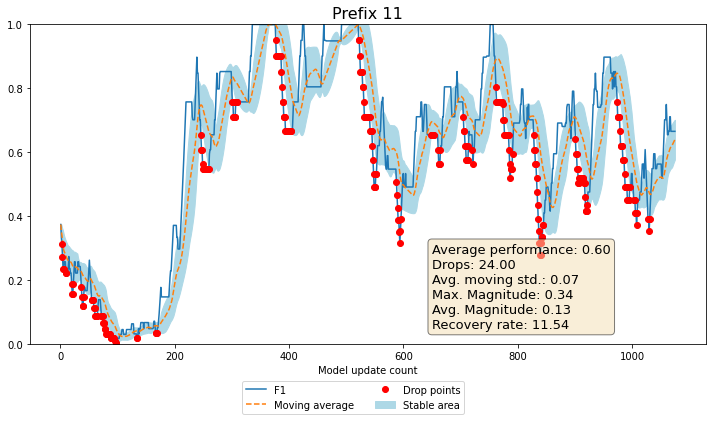

../img/bpic17/lstm/Finished cases/prefix_11_F1 update.png
12


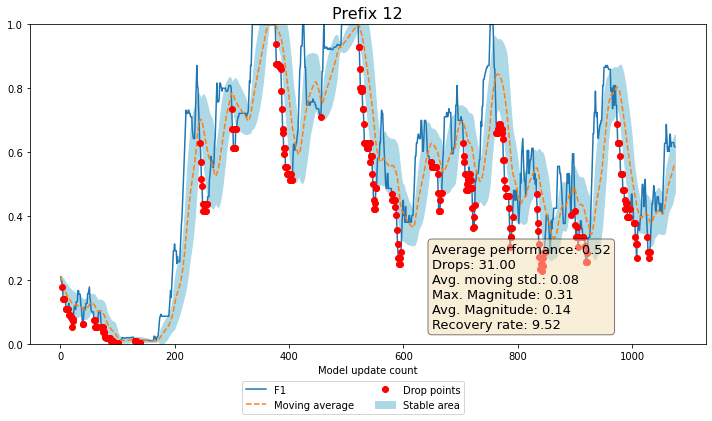

../img/bpic17/lstm/Finished cases/prefix_12_F1 update.png
13


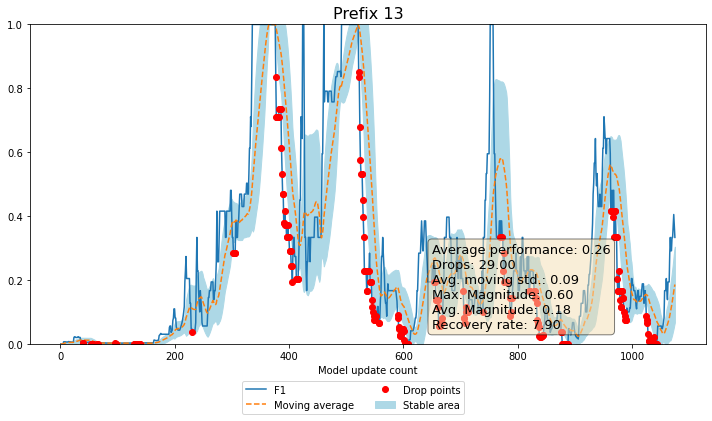

../img/bpic17/lstm/Finished cases/prefix_13_F1 update.png
14


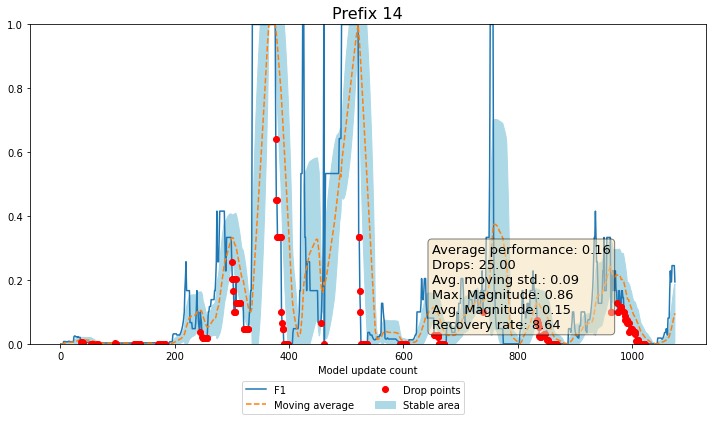

../img/bpic17/lstm/Finished cases/prefix_14_F1 update.png
15


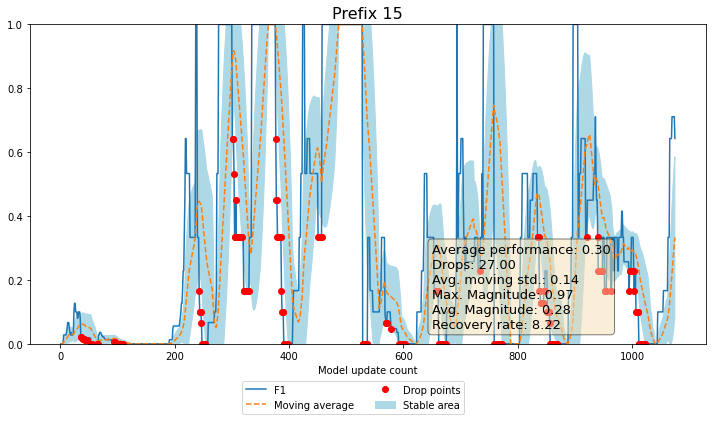

../img/bpic17/lstm/Finished cases/prefix_15_F1 update.png


In [12]:
meta_metrics_dict = dict()

for prefix in score_dict.keys():
    print(prefix)
    meta_metrics_dict[prefix] = dict()
    plt.figure(figsize=(10,6))
    mw_average, mw_std, outliers_pos = stability_window(score_dict[prefix],30)

    if len(outliers_pos) !=0:
        drop_list = list(drops(outliers_pos))
        drop_length = [i[1]- i[0] +1 for i in drop_list]
    
    x = [i for i in range(1, len(score_dict[prefix])+1)]
    y = score_dict[prefix]
    plt.plot(x, score_dict[prefix], label = evaluation_method)

    plt.plot(x, mw_average, linestyle = '--', label='Moving average')
    plt.fill_between(x, np.array(mw_average) + np.array(mw_std), np.array(mw_average) - np.array(mw_std), color='lightblue', label='Stable area')
    
    plt.plot([x[i] for i in outliers_pos], [y[i] for i in outliers_pos], 'ro', label = 'Drop points')

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol =2)
    plt.tight_layout()
#     plt.text(100, np.average(y), '%.2f'%(np.average(y)), va='center')   
    
    if len(outliers_pos) == 0:
        drops_value = 0
        avg_std = 0
        max_magnitude = 0
        avg_magnitude = 0
        recovery_rate = 0
    else:
        drops_value = len(drop_list)
        avg_std = np.average(mw_std)
        max_magnitude = np.max([mw_average[i] - y[i] for i in outliers_pos])
        avg_magnitude = np.average([mw_average[i] - y[i] for i in outliers_pos])
        recovery_rate = np.average(drop_length)
    eval_metrics = '\n'.join((
    r'Average performance: %.2f' %(np.average(y)),
    r'Drops: %.2f' %(drops_value),
    r'Avg. moving std.: %.2f'%(avg_std),
    r'Max. Magnitude: %.2f'%(max_magnitude),
    r'Avg. Magnitude: %.2f'%(avg_magnitude),
    r'Recovery rate: %.2f'%(recovery_rate)
    ))
    
    meta_metrics_dict[prefix]['Average performance'] = np.average(y)
    meta_metrics_dict[prefix]['Drops'] = drops_value
    meta_metrics_dict[prefix]['Avg. moving std.'] = avg_std
    meta_metrics_dict[prefix]['Max. Magnitude:'] = max_magnitude
    meta_metrics_dict[prefix]['Avg. Magnitude'] = avg_magnitude
    meta_metrics_dict[prefix]['Recovery rate'] = recovery_rate
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.text(650, 0.05, eval_metrics, bbox = props, fontsize = 13)
    
    
#     if dataset_label == 'bpic15' or dataset_label == 'bpic17':
#         pass
#     else:
#         plt.axvline(cdhappend[maximum_prefix], color = 'black', linestyle ='--', label = 'Concept drift')
    plt.title('Prefix %s'%(prefix), fontsize = 16)
    plt.xlabel('Model update count')
    plt.legend(bbox_to_anchor=(0.65, -0.1), ncol=2)
    plt.ylim(0,1)

    if os.path.exists('./img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
        os.makedirs('./img/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))
    if os.path.exists('./result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases')) == False:
        os.makedirs('./result/%s/%s/%s'%(dataset_label, classifier, 'Finished cases'))


#     with open('./result/%s/%s/Finished cases/prefix_%s_%s update.pkl'%(dataset_label, classifier, prefix, evaluation_method), 'wb') as f:
#         pkl.dump(result, f)
    plt.tight_layout()

#     if prefix == 7 or prefix == 14:
#         a = plt.gca()
#         yax = a.axes.get_yaxis()
#         yax = yax.set_visible(False)
    plt.show()
#     plt.savefig('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method), dpi=250)
    print('../img/%s/%s/Finished cases/prefix_%s_%s update.png'%(dataset_label, classifier, prefix, evaluation_method))
    plt.cla()
    plt.clf()
    plt.close()

In [13]:
meta_metrics_dict
headers = ['Prefix'] + list(meta_metrics_dict[1].keys())
table_list = []
for i in meta_metrics_dict.keys():
    rows = [i]
    for d in headers: 
        if d !='Prefix':
            rows.append(meta_metrics_dict[i][d])
    table_list.append(rows)
table = tabulate(table_list, headers=headers, tablefmt='grid')
print(table)
# print(tabulate([(i,) +d[i] for i in d], headers = headers)) 

+----------+-----------------------+---------+--------------------+-------------------+------------------+-----------------+
|   Prefix |   Average performance |   Drops |   Avg. moving std. |   Max. Magnitude: |   Avg. Magnitude |   Recovery rate |
+==========+=======================+=========+====================+===================+==================+=================+
|        1 |              0.607348 |      28 |          0.0679665 |          0.33099  |         0.125275 |        10.3929  |
+----------+-----------------------+---------+--------------------+-------------------+------------------+-----------------+
|        2 |              0.60622  |      27 |          0.0686776 |          0.33099  |         0.126725 |        10.4815  |
+----------+-----------------------+---------+--------------------+-------------------+------------------+-----------------+
|        3 |              0.60622  |      27 |          0.0686776 |          0.33099  |         0.126725 |        10.4815  |


In [59]:
df = pd.DataFrame.from_dict(meta_metrics_dict).T
df.to_csv('../result/%s_%s_%s.csv'%(dataset_label, classifier, evaluation_method), index=False)

In [60]:
'../result/%s_%s_%s.csv'%(dataset_label, classifier, evaluation_method)

'../result/synthetic_log_bc2_xgb_F1.csv'